In [25]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn 
import torch.optim as optim
import tqdm
import optuna
from optuna.importance import get_param_importances

In [26]:
# Configurações
BATCH_SIZE = 128
LATENT_DIM = 10
LEARNING_RATE = 0.0009
BETA1 = 0.16
BETA2 = 0.89
GP_SCALE = 17
IMG_SIZE = 28
NUM_CHANNELS = 1
NUM_CLASSES = 10
EPOCHS = 5
MODEL_PATH = f"wgan_{EPOCHS}e_{BATCH_SIZE}b_{LEARNING_RATE}lr_{BETA1}B1_{BETA2}B2_{GP_SCALE}gp.pth"

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# Transformação para normalizar imagens entre [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Carregar dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [29]:
classes = train_dataset.classes

In [30]:
# Camada de Convolução para o Discriminador
def conv_block(in_channels, out_channels, kernel_size=5, stride=2, padding=2, use_bn=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)]
    if use_bn:
        layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)

In [31]:
# Discriminador
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            conv_block(NUM_CHANNELS + NUM_CLASSES, 64, use_bn=False),
            conv_block(64, 128, use_bn=True),
            conv_block(128, 256, use_bn=True),
            conv_block(256, 512, use_bn=True),
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1)
        )

    def forward(self, x):
        return self.model(x)

In [32]:
# Camada de upsample para o Gerador
def upsample_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1, use_bn=True):
    layers = [
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels) if use_bn else nn.Identity(),
        nn.LeakyReLU(0.2, inplace=True)
    ]
    return nn.Sequential(*layers)

In [ ]:
# Gerador
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + NUM_CLASSES, 4 * 4 * 256),
            nn.BatchNorm1d(4 * 4 * 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (256, 4, 4)),
            upsample_block(256, 128),
            upsample_block(128, 64),
            upsample_block(64, 32),
            nn.Conv2d(32, NUM_CHANNELS, kernel_size=5, stride=1, padding=0),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

In [44]:
# Inicializar modelos
D = Discriminator().to(device)
G = Generator(latent_dim=LATENT_DIM).to(device)

In [ ]:
# Otimizadores
optimizer_D = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
optimizer_G = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

In [36]:
 # Função de perda Wasserstein
def discriminator_loss(real_output, fake_output):
    return fake_output.mean() - real_output.mean()

def generator_loss(fake_output):
    return -fake_output.mean()

In [37]:
# Função para calcular Gradient Penalty
def gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolated = D(interpolated)
    gradients = torch.autograd.grad(outputs=d_interpolated, inputs=interpolated,
                                    grad_outputs=torch.ones_like(d_interpolated),
                                    create_graph=True, retain_graph=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

In [42]:
# Função Objetiva (a ser otimizada pelo Optuna)
def objective(trial):
    # Escolher os hiperparâmetros dentro de um intervalo
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    latent_dim = trial.suggest_categorical("latent_dim", [10, 100, 128, 256])
    lr = trial.suggest_float("learning_rate", 0.0001, 0.05, log=True)
    beta1 = trial.suggest_float("beta1", 0.0, 0.9)
    beta2 = trial.suggest_float("beta2", 0.8, 0.999)
    gp_scale = trial.suggest_int("gp_scale", 0, 100)

    # Criar DataLoader com batch_size otimizado
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Criar novos modelos e otimizadores
    D = Discriminator().to(device)
    G = Generator(latent_dim=latent_dim).to(device)
    optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
    optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))

    G.train()
    D.train()

    total_loss = 0.0
    total_batches = 0

    # Treinar por algumas épocas
    for epoch in range(EPOCHS):
        epoch_loss = 0.0
        epoch_batches = 0
        progress_bar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

        for real_images, labels in progress_bar:
            real_images = real_images.to(device)
            labels = torch.nn.functional.one_hot(labels, NUM_CLASSES).float().to(device)

            image_labels = labels.view(labels.size(0), NUM_CLASSES, 1, 1).expand(-1, -1, IMG_SIZE, IMG_SIZE)
            real_images = torch.cat([real_images, image_labels], dim=1)

            # Treinar Discriminador
            z = torch.randn(real_images.size(0), latent_dim).to(device)
            z = torch.cat([z, labels], dim=1)
            fake_images = G(z).detach()
            fake_images = torch.cat([fake_images, image_labels], dim=1)

            optimizer_D.zero_grad()
            loss_D = discriminator_loss(D(real_images), D(fake_images)) + gp_scale * gradient_penalty(D, real_images, fake_images)
            loss_D.backward()
            optimizer_D.step()

            # Treinar Gerador
            optimizer_G.zero_grad()
            z = torch.randn(real_images.size(0),latent_dim).to(device)
            z = torch.cat([z, labels], dim=1)
            fake_images = G(z)
            loss_G = generator_loss(D(torch.cat([fake_images, image_labels], dim=1)))
            loss_G.backward()
            optimizer_G.step()

            epoch_loss += loss_G.item()
            total_loss += loss_G.item()
            total_batches += 1
            epoch_batches += 1

            progress_bar.set_postfix(d_loss=loss_D.item(), g_loss=loss_G.item())

        # Calcular a loss média dessa época
        epoch_avg_loss = epoch_loss / epoch_batches
        # Reporta a loss média da época para pruning
        trial.report(epoch_avg_loss, epoch)
        if trial.should_prune() and epoch >=3:
            raise optuna.exceptions.TrialPruned()
            

    avg_loss = total_loss / total_batches

    return avg_loss  # Optuna tentará minimizar essa métrica

# Criar estudo do Optuna e otimizar hiperparâmetros
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# Exibir os melhores hiperparâmetros encontrados
print("\n🔹 Melhores Hiperparâmetros Encontrados:")
print(study.best_params)

importance = get_param_importances(study)
print("Hyperparameter Importances:")
for param, imp in importance.items():
    print(f"{param}: {imp:.4f}")

[I 2025-02-19 12:49:49,833] A new study created in memory with name: no-name-11e7f975-4ca5-4afe-a9e2-0ec631fec7c5
Epoch 3/5: 100%|██████████| 938/938 [01:32<00:00, 10.11it/s, d_loss=0.0727, g_loss=-4.48]   
[I 2025-02-19 12:54:28,514] Trial 0 finished with value: -3.9330879538541748 and parameters: {'batch_size': 64, 'latent_dim': 128, 'learning_rate': 0.006598326371608068, 'beta1': 0.43171041230209667, 'beta2': 0.818720554793616, 'gp_scale': 55}. Best is trial 0 with value: -3.9330879538541748.
Epoch 3/5: 100%|██████████| 469/469 [00:50<00:00,  9.23it/s, d_loss=-0.224, g_loss=-1.31]  
[I 2025-02-19 12:57:01,064] Trial 1 finished with value: -1.1976218126388565 and parameters: {'batch_size': 128, 'latent_dim': 10, 'learning_rate': 0.00013027100879525158, 'beta1': 0.8180682355036079, 'beta2': 0.8667906762243146, 'gp_scale': 35}. Best is trial 0 with value: -3.9330879538541748.
Epoch 3/5: 100%|██████████| 938/938 [01:32<00:00, 10.11it/s, d_loss=0.0816, g_loss=0.264]    
[I 2025-02-19 13:


🔹 Melhores Hiperparâmetros Encontrados:
{'batch_size': 64, 'latent_dim': 256, 'learning_rate': 0.007043641840503328, 'beta1': 0.026576682334378245, 'beta2': 0.843182732409128, 'gp_scale': 92}
Hyperparameter Importances:
learning_rate: 0.5315
batch_size: 0.2889
gp_scale: 0.0749
beta1: 0.0617
latent_dim: 0.0261
beta2: 0.0170


In [63]:
BATCH_SIZE = 32
LEARNING_RATE = 0.002
GP_SCALE = 10
BETA1 = 0.5
BETA2 = 0.9
LATENT_DIM = 128
MODEL_PATH = f"wgan_{EPOCHS}e_{BATCH_SIZE}b_{LEARNING_RATE}lr_{BETA1}B1_{BETA2}B2_{GP_SCALE}gp_{LATENT_DIM}ld.pth"

In [64]:
device = "cuda"

In [65]:
# Inicializar modelos
D = Discriminator().to(device)
G = Generator(latent_dim=LATENT_DIM).to(device)
# Otimizadores
optimizer_D = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
optimizer_G = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

In [66]:
# Treinamento
for epoch in range(EPOCHS):
    print(f"\n🔹 Epoch {epoch+1}/{EPOCHS}")
    progress_bar = tqdm.tqdm(train_loader, desc=f"Treinando {epoch+1}/{EPOCHS}", leave=True)

    for real_images, labels in progress_bar:
        real_images = real_images.to(device)
        labels = torch.nn.functional.one_hot(labels, NUM_CLASSES).float().to(device)
        # Adicionar labels ao real_images para treinamento do Discriminador
        image_labels = labels.view(labels.size(0), NUM_CLASSES, 1, 1).expand(-1, -1, IMG_SIZE, IMG_SIZE)
        real_images = torch.cat([real_images, image_labels], dim=1)

        # Treinar Discriminador
        z = torch.randn(real_images.size(0), LATENT_DIM).to(device)
        z = torch.cat([z, labels], dim=1)
        fake_images = G(z).detach()
        fake_images = torch.cat([fake_images, image_labels], dim=1)

        optimizer_D.zero_grad() 
        D(real_images)
        loss_D = discriminator_loss(D(real_images), D(fake_images)) + GP_SCALE * gradient_penalty(D, real_images, fake_images)
        loss_D.backward()
        optimizer_D.step()

        # Treinar Gerador
        if epoch % 3 == 0:
            optimizer_G.zero_grad()
            z = torch.randn(real_images.size(0), LATENT_DIM).to(device)
            z = torch.cat([z, labels], dim=1)
            fake_images = G(z)
            loss_G = generator_loss(D(torch.cat([fake_images, image_labels], dim=1)))
            loss_G.backward()
            optimizer_G.step()

        progress_bar.set_postfix(d_loss=loss_D.item(), g_loss=loss_G.item())

    # Salvar modelo a cada época
    torch.save({"generator": G.state_dict(), "discriminator": D.state_dict()}, MODEL_PATH)

print("✅ Treinamento Concluído!")


🔹 Epoch 1/5


Treinando 1/5: 100%|██████████| 469/469 [01:00<00:00,  7.78it/s, d_loss=-0.5, g_loss=1.52]     



🔹 Epoch 2/5


Treinando 2/5: 100%|██████████| 469/469 [00:40<00:00, 11.68it/s, d_loss=-6.87, g_loss=1.52] 



🔹 Epoch 3/5


Treinando 3/5: 100%|██████████| 469/469 [00:40<00:00, 11.68it/s, d_loss=-11.3, g_loss=1.52] 



🔹 Epoch 4/5


Treinando 4/5: 100%|██████████| 469/469 [01:00<00:00,  7.82it/s, d_loss=0.513, g_loss=40.2]    



🔹 Epoch 5/5


Treinando 5/5: 100%|██████████| 469/469 [00:40<00:00, 11.68it/s, d_loss=-10.4, g_loss=40.2] 

✅ Treinamento Concluído!


In [48]:
import matplotlib.pyplot as plt

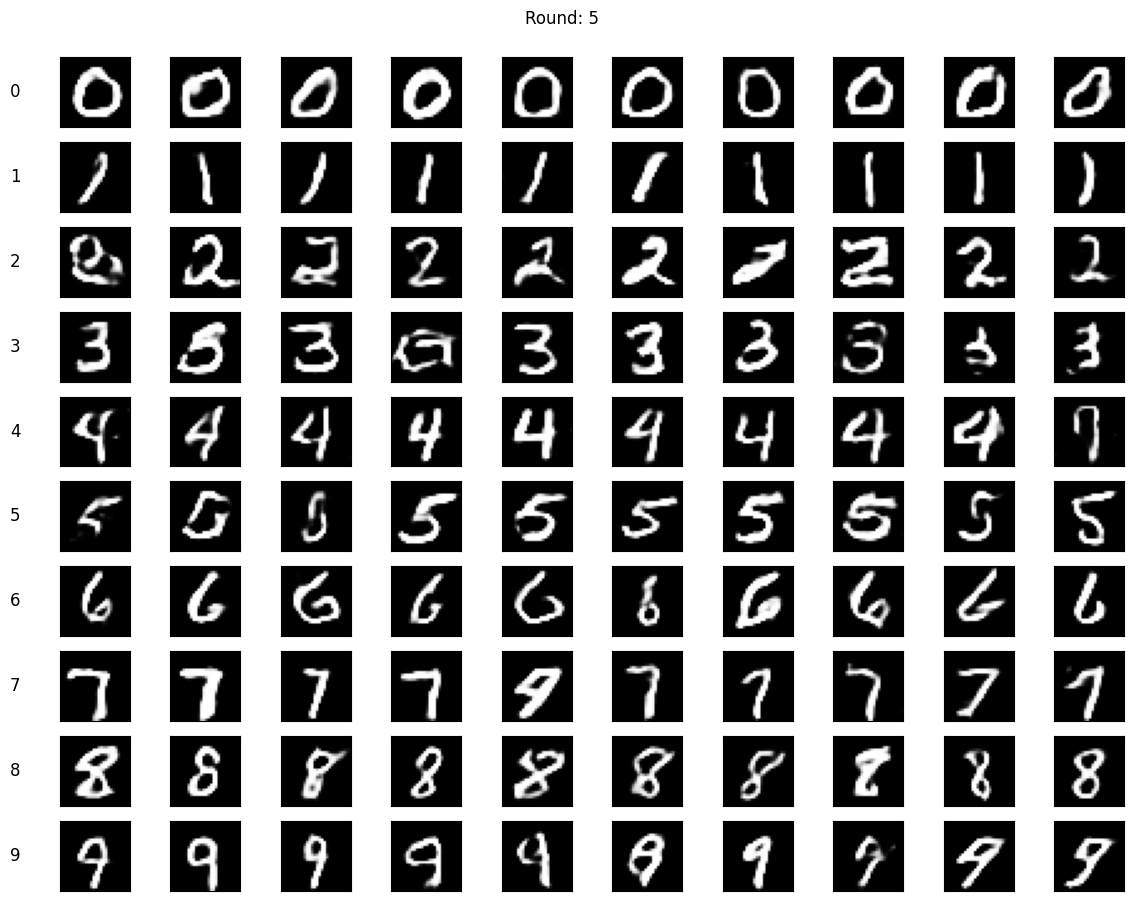

In [67]:
seed = 42
device = "cpu"
# random.seed(seed)
# np.random.seed(seed)
#torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
#G.load_state_dict(torch.load("wgan_checkpoint.pth")["generator"])
G.to(device)
path = ""
# Assuming netG is your generator model, classes is the total number of classes, and latent_dim is the latent vector size
examples_per_class = 10
classes = 10
batch_size = examples_per_class * classes  # Generate enough images to have `examples_per_class` for each class

# Generate latent vectors and corresponding labels
latent_vectors = torch.randn(batch_size, LATENT_DIM, device=device)
labels = torch.tensor([i for i in range(classes) for _ in range(examples_per_class)], device=device)
labels = torch.nn.functional.one_hot(labels, NUM_CLASSES).float().to(device)

# Generate images
with torch.no_grad():
    generated_images = G(torch.cat([latent_vectors, labels], dim=1))

# Criar uma figura com 10 linhas e 5 colunas de subplots
fig, axes = plt.subplots(classes, examples_per_class, figsize=(12, 9))

#fig.text(0.5, 0.98, f"Round: {round_number} | Client: {client_id}", ha="center", fontsize=12)

fig.text(0.5, 0.98, f"Round: {5}", ha="center", fontsize=12)

# Exibir as imagens nos subplots
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i, 0, :, :], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

# Ajustar o layout antes de calcular as posições
plt.tight_layout(rect=[0.05, 0, 1, 0.96])

# Reduzir espaço entre colunas
# plt.subplots_adjust(wspace=0.05)

# Adicionar os rótulos das classes corretamente alinhados
fig.canvas.draw()  # Atualiza a renderização para obter posições corretas
for row in range(classes):
    # Obter posição do subplot em coordenadas da figura
    bbox = axes[row, 0].get_window_extent(fig.canvas.get_renderer())
    pos = fig.transFigure.inverted().transform([(bbox.x0, bbox.y0), (bbox.x1, bbox.y1)])
    center_y = (pos[0, 1] + pos[1, 1]) / 2  # Centro exato da linha

    # Adicionar o rótulo
    fig.text(0.04, center_y, str(row), va='center', fontsize=12, color='black')
    plt.savefig(f"{path}WGAN_{EPOCHS}e_{BATCH_SIZE}b_{LEARNING_RATE}lr_{BETA1}B1_{BETA2}B2_{GP_SCALE}gp_{LATENT_DIM}ld.png")